In [1]:
import pandas as pd
import pickle
from netCDF4 import Dataset,num2date,date2num
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from calendar import monthrange
import datetime
import matplotlib.dates as mdates
import xarray as xr

### Gauge-based measurements
Daily precipitation measurements were submitted to an online repository from a location around 12 km
away from the facility (49.86306°N, -97.2621613°E). Measurements were taken at 7am every morning in a
standard 4 inch diameter rain gauge and uploaded to the Community Collaborative Rain, Hail and Snow
Network (CoCoRaHS; station CAN-MB-206). To generate a continuous timeseries, the SWE accumulation was spread evenly out
over the previous 24 hours.

### SWE from ERA5 reanalysis
Snowfall data was also taken from the ERA5 land reanalysis, which provides hourly data on a 0.1°×0.1°grid
(which has a resolution of ∼9 km. Values represent the hourly average precipitation (mmhr-1) over the grid
cell which is centered around 4 km away.

# Process Airport SWE Data and resample at 10 minute intervals

In [2]:
# https://www.cocorahs.org/ViewData/StationPrecipSummary.aspx
# CAN-MB-206

# I've just copied this list in from the website

SWE_mm = [1,1.5,"NA",8.1,1.8,0.2,"NA","NA","NA","T","T","NA",0.5,1,"T",0.2,"T",
          "NA",1.5,"T","NA","NA",1,"NA","T","T","T",0.5,0.8,"NA","NA","NA"]

# Hour = 7 because the gauge is checked at 7am, and +6 to go to UTC from Winnipeg in February

start_airport_date = datetime.datetime(year=2020, # Start date of the data I copied
                                       month=1,
                                       day=15,
                                       hour=7+6) 

airport_dates = [start_airport_date + timedelta(days=x) for x in range(len(SWE_mm))] # Makes the time axis

###########################################################

def clean_SWE_timeseries(SWE_mm):

    """A function that cleans the list at the top and returns a list of float datatypes.
    
    NA and T both mapped to 0"""

    SWE_mm_clean = []
    for i in SWE_mm:
        if isinstance(i, (float,int)):
            SWE_mm_clean.append(i)
        elif i in ['NA','T']:
            SWE_mm_clean.append(0)
        else:
            raise

    return(SWE_mm_clean)

SWE_mm_clean = clean_SWE_timeseries(SWE_mm)

############################################################
        
gauge_df = pd.DataFrame({'dt_':airport_dates,
                           'G_SWE_mm':SWE_mm_clean})

gauge_df['dt'] = pd.to_datetime(gauge_df['dt_'])

gauge_df.drop(columns='dt_',inplace=True)

gauge_df.set_index('dt',inplace=True)

gauge_df = gauge_df.resample('10min').bfill()

gauge_df['G_SWE_mm'] = gauge_df['G_SWE_mm']/144

gauge_df

,G_SWE_mm
dt,
2020-01-15 13:00:00,0.006944
2020-01-15 13:10:00,0.010417
2020-01-15 13:20:00,0.010417
2020-01-15 13:30:00,0.010417
2020-01-15 13:40:00,0.010417
...,...
2020-02-15 12:20:00,0.000000
2020-02-15 12:30:00,0.000000
2020-02-15 12:40:00,0.000000


# Quick plot of the data to check it's okay

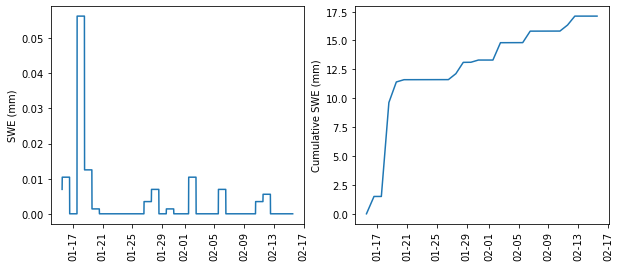

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,4))

date_form = mdates.DateFormatter("%m-%d")

ax1.plot(gauge_df.index, gauge_df['G_SWE_mm'])
ax1.tick_params('x',rotation=90)
ax1.set_ylabel('SWE (mm)')
ax1.xaxis.set_major_formatter(date_form)

ax2.set_ylabel('Cumulative SWE (mm)')
ax2.plot(gauge_df.index, np.cumsum(gauge_df['G_SWE_mm']))
ax2.tick_params('x',rotation=90)
ax2.xaxis.set_major_formatter(date_form)


# Process ERA5 Reanalysis Data

In [4]:
precip_data = Dataset('raw_ERA5_SERF.nc')
print(precip_data)

days_in_feb, days_in_jan = monthrange(2020, 2)[1], monthrange(2020, 1)[1]

hours_in_jan = days_in_jan * 24
hours_in_feb = days_in_feb * 24

hours_in_data = hours_in_jan + hours_in_feb

# https://apps.ecmwf.int/codes/grib/param-db/?id=228
# https://apps.ecmwf.int/codes/grib/param-db?id=144
print()
print(precip_data['latitude'][0])
print(precip_data['longitude'][0])


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-07-16 19:46:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1594928291.314253-18120-33-abe50599-3ffc-4ce1-8984-9c754edda3fb.nc /cache/tmp/abe50599-3ffc-4ce1-8984-9c754edda3fb-adaptor.mars.internal-1594928291.314831-18120-10-tmp.grib
    dimensions(sizes): longitude(2), latitude(1), time(1440)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 sf(time,latitude,longitude), int16 tp(time,latitude,longitude)
    groups: 


49.89
-97.2


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


## ERA5 Land Reanalysis are publicly available in the style-from-hell. 

## Essentially it's cumulative precipitation at hourly intervals over the 'forecast period', which is 24 hours every day. 

## So you've got to take the difference in the precipitation value every hour to get the precipitation rate for the previous hour, apart from the 24->0 break, where you don't take the diff, just the actual amount.

In [5]:
total_precip = np.array(precip_data['tp'])[:,0,1]*1000 # total precipitation in mm
snowfall = np.array(precip_data['sf'][:,0,1])*1000

hourly_snowfall = [snowfall[0]]

for i in range(len(snowfall)-1):

    diff = snowfall[i+1] - snowfall[i]
    if i%24 == 0:
        diff = snowfall[i+1]

    hourly_snowfall.append(diff)

In [6]:
start_datetime = datetime.datetime(year=2020,month=1,day=1,hour=0)

datetimes = [start_datetime + timedelta(hours=x) for x in range(1440)]

ERA5_df = pd.DataFrame({'dt':datetimes,
                          'E5_SWE_mm':hourly_snowfall})

ERA5_df.set_index('dt',inplace=True)

ERA5_df = ERA5_df.loc['2020-1-15':'2020-2-15']

ERA5_df_ten_min = ERA5_df.resample('10min').bfill()
ERA5_df_ten_min['E5_SWE_mm'] = ERA5_df_ten_min['E5_SWE_mm']/6

print(ERA5_df_ten_min.head())



                     E5_SWE_mm
dt                            
2020-01-15 00:00:00   0.000360
2020-01-15 00:10:00   0.000336
2020-01-15 00:20:00   0.000336
2020-01-15 00:30:00   0.000336
2020-01-15 00:40:00   0.000336


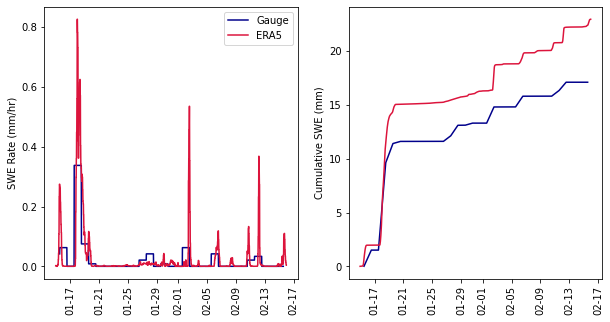

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

date_form = mdates.DateFormatter("%m-%d")

ax1.plot(gauge_df.index, gauge_df['G_SWE_mm']*6,label='Gauge',color='darkblue')
ax1.plot(ERA5_df_ten_min.index, ERA5_df_ten_min['E5_SWE_mm']*6,label=f'ERA5',color='crimson')
ax1.tick_params('x',rotation=90)
ax1.set_ylabel('SWE Rate (mm/hr)')
ax1.xaxis.set_major_formatter(date_form)
ax1.legend()


ax2.set_ylabel('Cumulative SWE (mm)')
ax2.plot(gauge_df.index, np.cumsum(gauge_df['G_SWE_mm']),label='Gauge',color='darkblue')
ax2.plot(ERA5_df_ten_min.index, np.cumsum(ERA5_df_ten_min['E5_SWE_mm']),label=f'ERA5',color='crimson')
ax2.tick_params('x',rotation=90)
ax2.xaxis.set_major_formatter(date_form)

plt.savefig('SWE_forcing.jpg',dpi=400,bbox_inches='tight')

# Pickle a combined dataframe for Python user's convenience

In [10]:
# Merge dataframes

SWE_forcing = pd.concat([ERA5_df_ten_min, gauge_df], axis=1)

with open('SWE_forcing.p', 'wb') as f:
    pickle.dump(SWE_forcing, f)

In [11]:
# Load the file back in to check it worked

with open('SWE_forcing.p', 'rb') as f:
    SWE_forcing = pickle.load(f)
    
SWE_forcing.head() # Nans in the gauge head nothing to worry about!

,E5_SWE_mm,G_SWE_mm
dt,,
2020-01-15 00:00:00,0.000360,NaN
2020-01-15 00:10:00,0.000336,NaN
2020-01-15 00:20:00,0.000336,NaN
2020-01-15 00:30:00,0.000336,NaN
2020-01-15 00:40:00,0.000336,NaN


# Output to a netcdf file for a metadata & language-independent data set

In [85]:
# Make netcdf

# You can't save python objects like datetimes in netcdf, so convert to Unix time

coords = {'time': (['t'], date2num(SWE_forcing.index.to_pydatetime(), "seconds since 1970-01-01T00:00:00"))}

variable = {'Gauge SWE (mm)': (['t'], SWE_forcing['G_SWE_mm']),
            'ERA5 SWE (mm)': (['t'], SWE_forcing['E5_SWE_mm'])}


ds = xr.Dataset(data_vars= variable,
                coords=coords)

ds.attrs['Author'] = 'Robbie Mallett CPOM UCL'
ds.attrs['Contact Email'] = 'robbie.mallett.17@ucl.ac.uk'
ds.attrs['Time information'] = 'Time axis in seconds since 1970-01-01T00:00:00 (Unix Time).'
ds.attrs['SWE information'] = """
SWE measured in mm fallen over the ten minute timestep. Data period 15th Jan 2020 to 15th Feb."""
ds.attrs['Gauge information'] = """
Daily precipitation measurements were submitted to an online repository from a location around 12 km
away from the facility (49.86306°N, -97.2621613°E). Measurements were taken at 7am every morning in a
standard 4 inch diameter rain gauge and uploaded to the Community Collaborative Rain, Hail and Snow
Network (CoCoRaHS; station CAN-MB-206). To generate a continuous timeseries, the SWE accumulation was spread evenly out
over the previous 24 hours."""
ds.attrs['ERA5 information'] = """
Snowfall data was also taken from the ERA5 land reanalysis, which provides hourly data on a 0.1°×0.1°grid
(which has a resolution of ∼9 km. Values represent the hourly average precipitation (mmhr-1) over the grid
cell which is centered around 4 km away."""


ds.to_netcdf(f'SWE.nc', 'w')

# Test the netcdf to make sure it worked

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Author: Robbie Mallett CPOM UCL
    Contact Email: robbie.mallett.17@ucl.ac.uk
    Time information: Time axis in seconds since 1970-01-01T00:00:00 (Unix Time).
    SWE information: SWE measured in mm fallen over the ten minute timestep. Data period: 15th Jan 2020 to 15th Feb 2020.
    Gauge information: 
Daily precipitation measurements were submitted to an online repository from a location around 12 km
away from the facility (49.86306°N, -97.2621613°E). Measurements were taken at 7am every morning in a
standard 4 inch diameter rain gauge and uploaded to the Community Collaborative Rain, Hail and Snow
Network (CoCoRaHS; station CAN-MB-206). To generate a continuous timeseries, the SWE accumulation was spread evenly out
over the previous 24 hours.
    ERA5 information: 
Snowfall data was also taken from the ERA5 land reanalysis, which provides hourly data on a 0.1°×0.1°grid
(which has a resolution

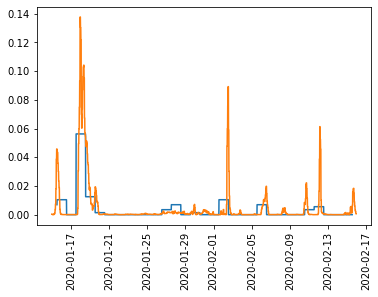

In [12]:
# read

data = Dataset('SWE.nc')

print(data)

# plot

G_SWE = data['Gauge SWE (mm)']
E5_SWE = data['ERA5 SWE (mm)']
time = data['time']


datetimes = num2date(time, "seconds since 1970-01-01T00:00:00", 
                     only_use_cftime_datetimes=False,
                     only_use_python_datetimes=True)

plt.plot(datetimes, G_SWE)
plt.plot(datetimes, E5_SWE)
plt.tick_params('x',rotation=90)
plt.show()